In [51]:
from selenium import webdriver   
from bs4 import BeautifulSoup
from IPython.core.display import HTML
import os
import pandas as pd
import time
from datetime import date
import string
import glob
from IPython.display import Image
from IPython.display import display

Choose the expiration time by using
Dec 2016, Jan 2017 and Feb 2017.

In [2]:
stocks = ['GOOG','YHOO','AAPL','MSFT','AMZN','JPM','BAC','HSBC','CIT','GS']

In [3]:
#12.16; 1.20, 2.17; 
dates = ['1481846400','1484870400','1487289600']
maturity_dates = [date(2016,12,16),date(2016,1,20),date(2016,2,17)]

In [19]:
(date(2016,12,16) - date.today()).days/365

0.18356164383561643

** Example **

In [21]:
url = 'http://finance.yahoo.com/quote/GOOG/options?straddle=true&date=1481846400'
chromedriver = "/Users/Miya/Downloads/chromedriver.exe"
os.environ["webdriver.chrome.driver"] = chromedriver
driver = webdriver.Chrome(chromedriver)
driver.get(url)
html_source = driver.page_source 
table = soup.findAll('table','straddles')
table_html = str(table)
HTML(table_html)

Last Price,Change,% Change,Volume,Open Interest,Strike,Last Price,Change,% Change,Volume,Open Interest
302.80,0.00,0.00%,1,4,440.00,0.20,0.00,0.00%,2,6
323.00,30.10,10.28%,1,4,450.00,0.10,0.00,0.00%,1,77
261.00,0.00,0.00%,4,6,460.00,0.65,0.00,0.00%,1,1
251.10,0.00,0.00%,2,7,470.00,1.00,0.00,0.00%,1,23
292.80,0.00,0.00%,1,35,480.00,0.31,0.00,0.00%,7,115
-,-,-,-,-,490.00,1.05,0.00,0.00%,1,22
280.10,0.00,0.00%,1,9,500.00,0.20,0.00,0.00%,25,106
270.90,0.00,0.00%,1,4,520.00,0.25,-0.25,-50.00%,1,62
248.77,0.00,0.00%,1,9,540.00,0.59,0.00,0.00%,50,120
211.70,0.00,0.00%,1,46,560.00,0.50,-0.20,-28.57%,1,81


## Crawl All Data

**Option Data on Yahoo Finance is dynamic.(Javascript) Therefore, small tricks are needed when BeautifulSoup is used.**

In [52]:
chromedriver = "/Users/Miya/Downloads/chromedriver.exe"
os.environ["webdriver.chrome.driver"] = chromedriver
driver = webdriver.Chrome(chromedriver)
df_dict = {}
today = date.today()
for stock in stocks:
    for date,maturity in zip(dates,maturity_dates):
        ## Get the url
        url = 'http://finance.yahoo.com/quote/'+ stock +'/options?straddle=true&date='+ date
        ## Crawl data
        driver.get(url)
        html_source = driver.page_source 
        ## Beautifulsoup
        soup = BeautifulSoup(html_source,'html.parser')  
        
        if soup.find('table','straddles') is not None:
            
            title = [i.text for i in soup.find('table','straddles').find_all('th')]
            text = [i.text for i in soup.find('table','straddles').find_all('td')]
            rows = [row for row in soup.find('table','straddles').find_all("tr")]

            l_table = len(rows) - 1
        ## call data 
            dictionary_call = {}
            dictionary_call['type'] =  ['Call']*l_table
            dictionary_call['option'] = [stock]*l_table
            dictionary_call['maturity_date'] = [maturity]*l_table
            dictionary_call['date'] = [today]*l_table
        
            for j in range(6):
                key = title[j]
                dictionary_call[key] = []
                for i in range(l_table):
                    dictionary_call[key].append(text[11*i+j])
                
                
        ## put data        
            dictionary_put = {}
            dictionary_put['type'] =  ['Put']*l_table
            dictionary_put['option'] = [stock]*l_table
            dictionary_put['maturity_date'] = [maturity]*l_table
            dictionary_put['date'] = [today]*l_table
        
            for j in range(5,11):
                key = title[j]
                dictionary_put[key] = []
                for i in range(l_table):
                    dictionary_put[key].append(text[11*i+j])
                
        ## write into dataframe
            df_put = pd.DataFrame(dictionary_put)
            df_call = pd.DataFrame(dictionary_call)
            
            df = pd.concat([df_call,df_put],ignore_index =  True)        
            #df.to_csv(stock+date+'.csv')

            if stock not in df_dict.keys():
                df_dict[stock] = df
            else:
                df_dict[stock] = pd.concat([df_dict[stock],df],ignore_index =  True) 

In [54]:
print('We now have %d dataframes' % len(df_dict.keys()))

We now have 10 dataframes


** Save them into csv **

In [55]:
pwd

"C:\\Users\\Miya\\OneDrive\\Miya'sGithub\\Financial-Modeling"

mkdir data-quiz5

In [56]:
cd data-quiz5

C:\Users\Miya\OneDrive\Miya'sGithub\Financial-Modeling\data-quiz5


In [57]:
for key in df_dict.keys():
    name = key + '.csv'
    df_dict[key].to_csv(name)

** Sample DataFrame **

In [58]:
df_dict['AAPL'].columns

Index(['% Change', 'Change', 'Last Price', 'Open Interest', 'Strike', 'Volume',
       'date', 'maturity_date', 'option', 'type'],
      dtype='object')

In [60]:
df_dict['AAPL'].isnull().any()

% Change         False
Change           False
Last Price       False
Open Interest    False
Strike           False
Volume           False
date             False
maturity_date    False
option           False
type             False
dtype: bool

In [65]:
df_dict['AAPL'].dtypes

% Change         object
Change           object
Last Price       object
Open Interest    object
Strike           object
Volume           object
date             object
maturity_date    object
option           object
type             object
dtype: object

## Problem  One: Implied Volatility Surface

In [9]:
import numpy as np
import matplotlib.pyplot as plot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

**Implied volatility surface need time to maturity and strike price**

In [61]:
pwd

"C:\\Users\\Miya\\OneDrive\\Miya'sGithub\\Financial-Modeling\\data-quiz5"

In [62]:
cd ../

C:\Users\Miya\OneDrive\Miya'sGithub\Financial-Modeling


In [63]:
mkdir implied-volatility-surface

A subdirectory or file implied-volatility-surface already exists.


In [64]:
cd implied-volatility-surface

C:\Users\Miya\OneDrive\Miya'sGithub\Financial-Modeling\implied-volatility-surface


### Prepare dataframe

In [72]:
## remove , in dataframe
def remove_punctuation(dataframe):
    columns_to_set = ['Last Price','Open Interest','Strike','Volume']
    for i in columns_to_set:
        series = dataframe[i]
        series_new = []
        for j in series:
            j = str(j)
            j_new = ''.join(ch for ch in j if ch != ',')
            series_new.append(j_new)
        dataframe[i] = series_new
    return dataframe

In [73]:
for key in df_dict.keys():
    dataframe = df_dict[key]
    df_dict[key] = remove_punctuation(dataframe)

In [74]:
df_dict['AAPL'].head()

,% Change,Change,Last Price,Open Interest,Strike,Volume,date,maturity_date,option,type
0,0.00%,0.00,86.2,0.0,30.0,66.0,2016-10-12,2016-12-16,AAPL,Call
1,0.00%,0.00,71.55,0.0,45.0,7.0,2016-10-12,2016-12-16,AAPL,Call
2,0.00%,0.00,66.9,21.0,50.0,7.0,2016-10-12,2016-12-16,AAPL,Call
3,NaN,NaN,nan,nan,55.0,nan,2016-10-12,2016-12-16,AAPL,Call
4,0.00%,0.00,58.0,10.0,60.0,5.0,2016-10-12,2016-12-16,AAPL,Call


In [75]:
## change the dtype 
columns_to_change = ['Last Price','Open Interest','Strike','Volume']
for key in df_dict.keys():
    ## detect nan
    df_dict[key] = df_dict[key].replace('-',np.nan)
    for i in columns_to_change:
        df_dict[key][i] = df_dict[key][i].astype(float)

In [76]:
## check the dtype
df_dict['AAPL'].dtypes 

% Change          object
Change            object
Last Price       float64
Open Interest    float64
Strike           float64
Volume           float64
date              object
maturity_date     object
option            object
type              object
dtype: object

In [77]:
df_dict['AAPL'].isnull().any()

% Change          True
Change            True
Last Price        True
Open Interest     True
Strike           False
Volume            True
date             False
maturity_date    False
option           False
type             False
dtype: bool

In [79]:
for key in df_dict.keys():
    time_to_maturity = []
    ## grab dataframe, then relevant data
    for i, j in zip(df_dict[key].maturity_date,df_dict[key].date):
        time_to_maturity.append((i - j).days/365)
        
    strike_price = df_dict[key].Strike
    
    strike_price, time_to_maturity = np.meshgrid(strike_price, time_to_maturity)
    
    # generate pseudo-implied volatility by using strike price and time-to-maturity as parameters
    implied_vol = ((strike_price - 150)**2)/(150 * strike_price)/(np.power(time_to_maturity, 0.95))
    
    fig = plot.figure(figsize = (10,5)) ## a plot object
    ax = Axes3D(fig) # create a 3D object/handle
    
    ##plot surface: array row/column stride(step size:2)
    
    surf = ax.plot_surface(strike_price, time_to_maturity, implied_vol, rstride = 2, cstride = 2, cmap = cm.coolwarm, linewidth = 0.5, antialiased = False)
    #set x,y,a labels
    ax.set_xlabel('Strike Price')
    ax.set_ylabel('time to maturity')
    ax.set_zlabel('implied volatility')
    plot.suptitle(key)
    
    fig.savefig(key+'.png', dpi=fig.dpi)


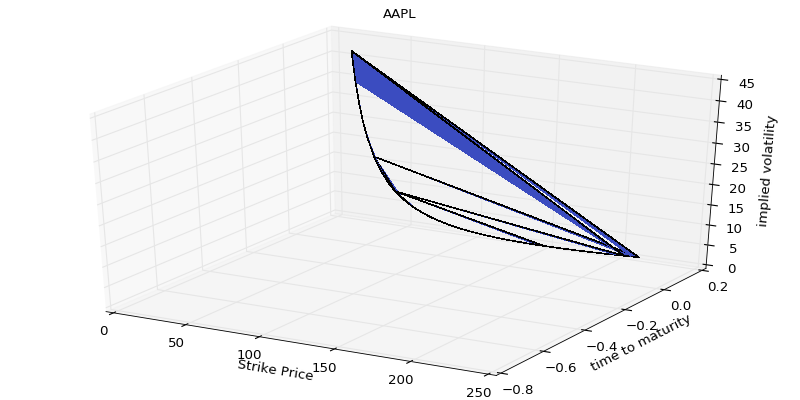

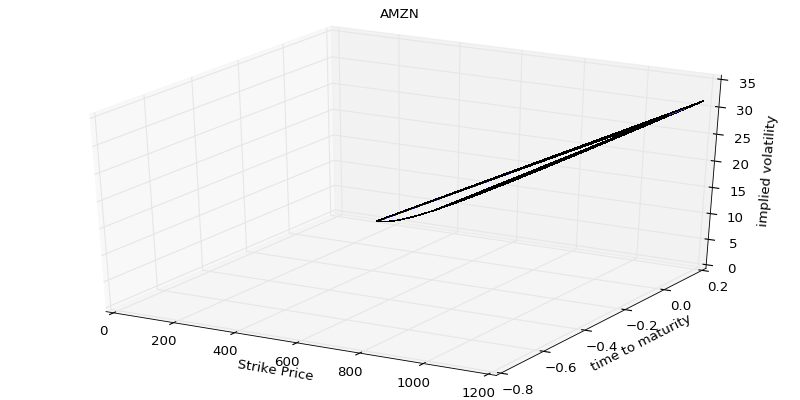

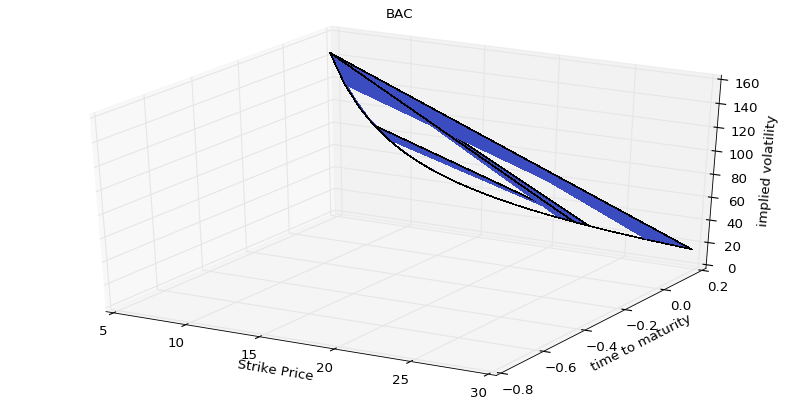

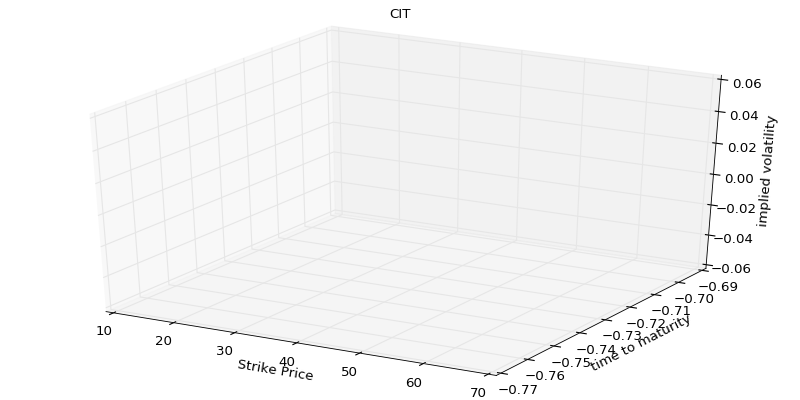

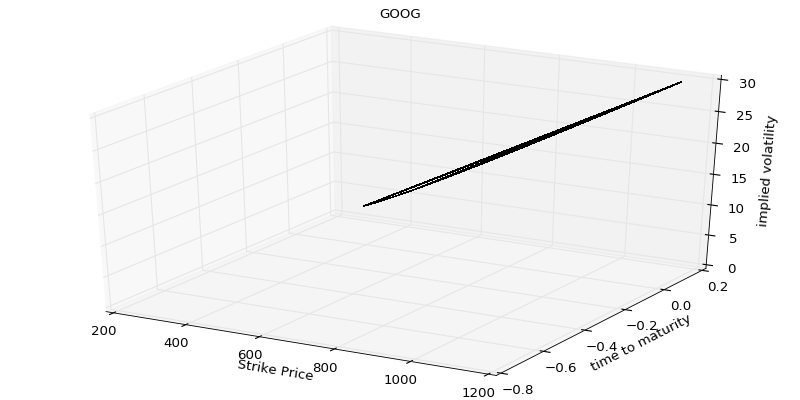

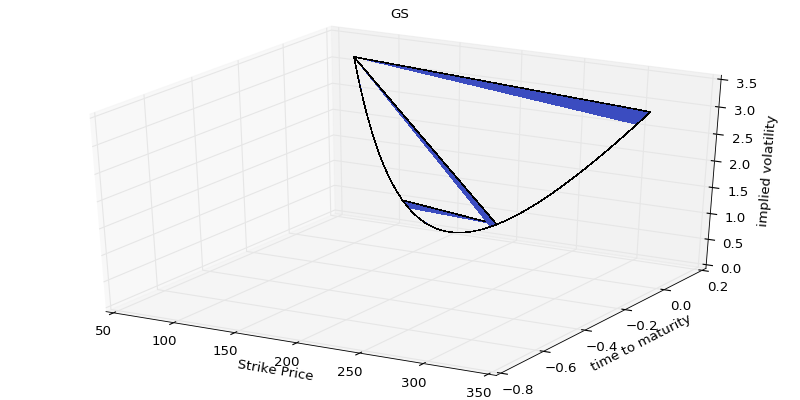

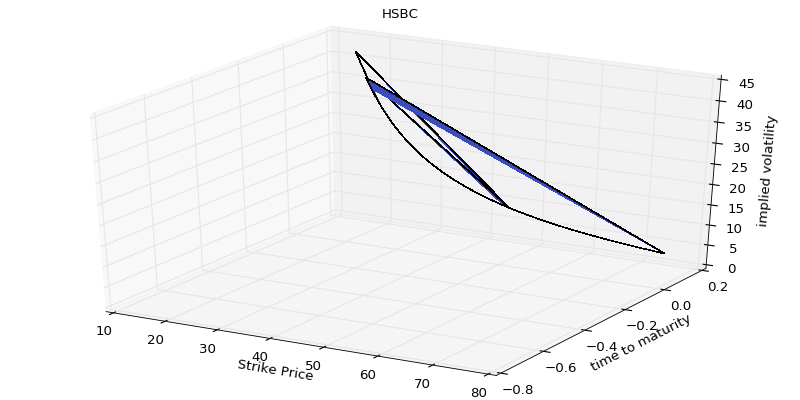

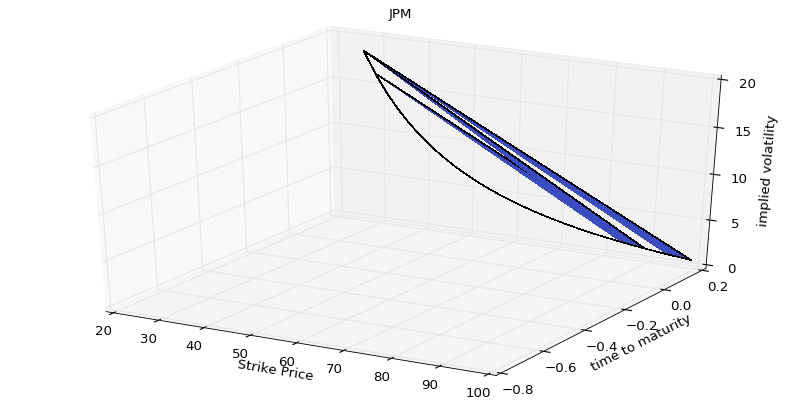

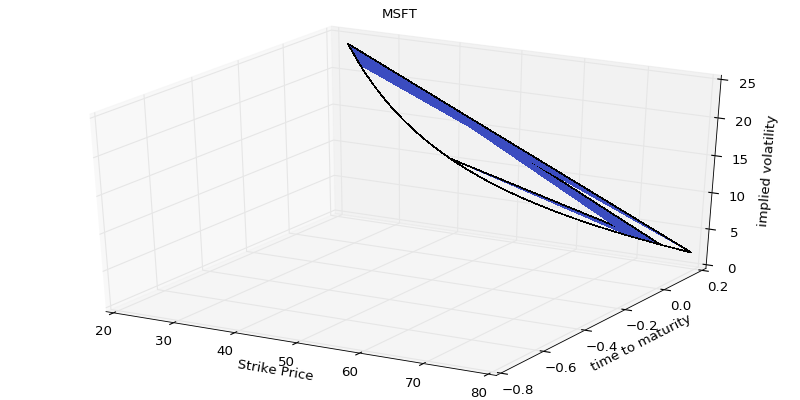

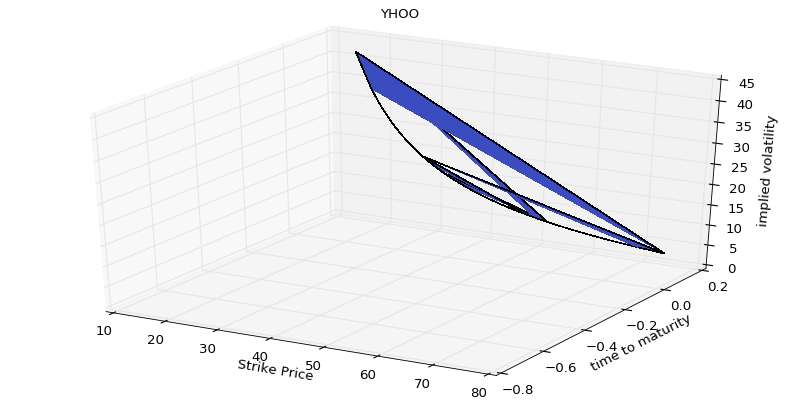

In [88]:
for filename in glob.glob('*'):
    display(Image(filename))